# Tarea 2: NLP, RNNs y Transformer

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import re

import numpy as np              # Procesamiento numérico
import pandas as pd             # Manipulación de conjuntos de datos
import matplotlib.pyplot as plt # Gráficos

import matplotlib.ticker as ticker

from tqdm import tqdm

from torch.utils.data import DataLoader, Subset

import torch
import torch.nn as nn
import torch.nn.functional as F

## Carga del dataset

Para la tarea se utilizará el dataset IMDB, el cual consiste en reseñas de películas con sus respectivas etiquetas de si es una reseña positiva o negativa.

El dataset se encuentra disponible en HuggingFace, asi que se puede cargar directamente.

**Nota:** Para descargar el dataset se tiene que instalar previamente la librería "datasets"

In [570]:
# # installing datasets package
# !pip install datasets

In [3]:
from datasets import load_dataset

c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
dataset = load_dataset("stanfordnlp/imdb")

Using the latest cached version of the dataset since stanfordnlp/imdb couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'plain_text' at C:\Users\Bruno\.cache\huggingface\datasets\stanfordnlp___imdb\plain_text\0.0.0\e6281661ce1c48d982bc483cf8a173c1bbeb5d31 (last modified on Sat May 11 19:55:56 2024).


In [5]:
data_train = pd.DataFrame(dataset["train"])
data_test = pd.DataFrame(dataset["test"])

# shuffle datasets

data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

data_train.head()

,text,label
0,Gday Mates! just watched Croc Hunter the movie...,0
1,This movie needs to be put on DVD. It was so f...,1
2,Kolchak is sheer entertainment. Great stories ...,1
3,This must have been one of the worst movies I ...,0
4,"In the wake of Lock, Stock and Two Smoking Bar...",0


In [90]:
# fraction dataset

fraction = 1
data_train = data_train.sample(frac=fraction).reset_index(drop=True)
data_test = data_test.sample(frac=fraction).reset_index(drop=True)

In [91]:
# tokenization
from nltk.tokenize import word_tokenize
import nltk
from bs4 import BeautifulSoup

nltk.download('punkt')

token_data_train = data_train.copy()
token_data_test = data_test.copy()

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # Remove special characters and multiple spaces
    text = re.sub(r'[^a-zA-Z0-9\s.,]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    return text.strip()

token_data_train["text"] = token_data_train["text"].apply(clean_text)
token_data_test["text"] = token_data_test["text"].apply(clean_text)

token_data_train["text"] = token_data_train["text"].apply(word_tokenize)
token_data_test["text"] = token_data_test["text"].apply(word_tokenize)

token_data_train.head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Bruno\AppData\Local\Temp\ipykernel_17520\1763248502.py:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text(separator=" ")


,text,label
0,"[the, narrative, affirms, the, classic, image,...",1
1,"[i, can, t, say, i, liked, this, movie, very, ...",0
2,"[i, saw, this, film, without, to, know, what, ...",1
3,"[it, is, unusual, to, see, a, film, where, the...",1
4,"[some, war, movies, succeed, where, others, do...",1


In [92]:
# vocabulary
from collections import Counter

vocab = Counter()

for text in token_data_train["text"]:
    vocab.update(text)

In [93]:
# Define the vocabulary size based on the most common words
vocabulary_size = 20000

# Get the most common words up to the specified vocabulary size
most_common_words = vocab.most_common(vocabulary_size)
print(most_common_words[:10])

# Define num_embeddings
vocab_size = vocabulary_size + 2

# Create word-to-index mapping with padding and unknown tokens
word_to_index = {word: index + 2 for index, (word, count) in enumerate(most_common_words)}
word_to_index["<PAD>"] = 0
word_to_index["<UNK>"] = 1

# Create index-to-word mapping
index_to_word = {index: word for word, index in word_to_index.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<UNK>"

# Define a function to encode text using the word-to-index mapping
def encode_text(text):
    return [word_to_index.get(word, 1) for word in text]

# Apply the encoding function to the 'text' column of token_data_train and token_data_test
token_data_train["text"] = token_data_train["text"].apply(encode_text)
token_data_test["text"] = token_data_test["text"].apply(encode_text)

# Display the modified token_data_train
token_data_train.head()

[('the', 336136), (',', 275888), ('.', 269453), ('and', 164054), ('a', 162713), ('of', 145851), ('to', 135700), ('is', 107326), ('it', 96103), ('in', 93922)]


,text,label
0,"[2, 1315, 1, 2, 354, 1456, 7, 53, 4011, 445, 1...",1
1,"[12, 51, 25, 136, 12, 427, 13, 20, 57, 1, 48, ...",0
2,"[12, 220, 13, 22, 209, 8, 125, 50, 46, 72, 77,...",1
3,"[10, 9, 1719, 8, 68, 6, 22, 121, 2, 240, 7, 6,...",1
4,"[52, 325, 103, 3126, 121, 409, 83, 26, 3, 5, 1...",1


In [94]:
def pad_text(text, length):
    return text[:length] if len(text) > length else text + [0] * (length - len(text))

In [95]:
# padding

text_max_length = np.max(token_data_train["text"].apply(len))
text_mean_length = int(np.mean(token_data_train["text"].apply(len)))
text_median_length = int(np.median(token_data_train["text"].apply(len)))

print(f"Max length: {text_max_length}")
print(f"Mean length: {text_mean_length}")
print(f"Median length: {text_median_length}")

token_data_train["text"] = token_data_train["text"].apply(pad_text, length=text_median_length//4)
token_data_test["text"] = token_data_test["text"].apply(pad_text, length=text_max_length)

token_data_train.head()

Max length: 2699
Mean length: 260
Median length: 194


,text,label
0,"[2, 1315, 1, 2, 354, 1456, 7, 53, 4011, 445, 1...",1
1,"[12, 51, 25, 136, 12, 427, 13, 20, 57, 1, 48, ...",0
2,"[12, 220, 13, 22, 209, 8, 125, 50, 46, 72, 77,...",1
3,"[10, 9, 1719, 8, 68, 6, 22, 121, 2, 240, 7, 6,...",1
4,"[52, 325, 103, 3126, 121, 409, 83, 26, 3, 5, 1...",1


In [96]:
# create validation set

validation_size = 0.2
validation_samples = int(len(token_data_train) * validation_size)

final_val = token_data_train[:validation_samples]
final_train = token_data_train[validation_samples:]
final_test = token_data_test

In [97]:
final_train.reset_index(drop=True, inplace=True)
final_train.head()

,text,label
0,"[56, 12, 220, 13, 20, 1097, 3, 2, 87, 157, 12,...",0
1,"[475, 1, 301, 6, 9244, 3770, 38, 190, 3, 2925,...",0
2,"[2, 13052, 554, 10, 33, 3, 13, 9, 32, 67, 79, ...",0
3,"[1803, 8, 2, 272, 2, 236, 7, 2, 2368, 1684, 64...",1
4,"[840, 671, 12, 204, 4624, 9, 66, 88, 7, 2, 897...",0


 Por motivos de costo computacional y tiempo de entrenamiento, para la tarea pueden considerar una proporción del dataset,  por ejemplo el 10%. Pero tenga en consideración que si el tamaño del dataset es muy pequeño el rendimiento del modelo se verá afectado negativamente.

In [98]:
# PyTorch datasets

from torch.utils.data import Dataset

class IMDBDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.data["text"][index]), torch.tensor(self.data["label"][index])

In [99]:
train_dataset = IMDBDataset(final_train)
val_dataset = IMDBDataset(final_val)
test_dataset = IMDBDataset(final_test)

# Report split sizes
print('Training set has {} instances'.format(len(final_train)))
print('Validation set has {} instances'.format(len(final_val)))
print('Test set has {} instances'.format(len(final_test)))

# PyTorch dataloaders

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set has 20000 instances
Validation set has 5000 instances
Test set has 25000 instances


## Parte 1: Redes Neuronales Recurrentes (RNNs)

### Actividad 1

Responda las siguientes preguntas:


*   ¿Cuáles son las principales características de las redes neuronales recurrentes?

    **Respuesta:** Las redes neuronales recurrentes, como su nombre indica, poseen conexiones recurrentes
    lo que permite que la red mantenga una memoria de los datos que ha procesado previamente,
    de forma que el _output_ en un estado particual esta influenciado no solo por su _input_ actual
    sino también por los _inputs_ previos.
    
    Las RNN tienen la capacidad de recibir _inputs_ de longitud variable y producir _outputs_ de longitud variable.

*   ¿Cuáles son las desventajas y limitaciones de las redes RNNs?

    **Respuesta:** Las RNNs sufren del problema de desvanecimiento y explosión del gradiente, lo que
    dificulta el entrenamiento de la red. Además, las RNNs tienen dificultades para mantener
    la memoria a largo plazo, lo que limita su capacidad para recordar información relevante
    de _inputs_ muy antiguos. Por el contrario, las RNNs también tienen problemas para olvidar
    información irrelevantes de _inputs_ recientes que no son relevantes para el _output_.

*   Menciona y describa brevemente al menos dos variantes a la arquitectura de RNNs simples.

    **Respuesta:** LSTM: Las redes LSTM (Long Short-Term Memory) son una variante de las RNNs que
    intentan solucionar el problema de la memoria a largo plazo. Las LSTM poseen una estructura
    más compleja que las RNNs tradicionales, con una estructura de celdas que permiten mantener
    la memoria a largo plazo y olvidar información irrelevante.

    GRU: Las redes GRU (Gated Recurrent Unit) son una variante de las RNNs que intentan simplificar
    la estructura de las LSTM, eliminando la estructura de celdas y manteniendo solo las puertas
    de olvido y actualización. Las GRU son más simples que las LSTM y tienen menos parámetros,
    lo que las hace más fáciles de entrenar y menos propensas al sobreajuste.

    Modelos de atención: Los modelos de atención son una variante de las RNNs que permiten
    que la red se enfoque en partes específicas de la secuencia de _inputs_ para generar el _output_,
    asignando pesos a los _inputs_ en vez de asignar el mismo peso a todos los _inputs_ como lo hacen
    las RNNs tradicionales. 

### Actividad 2

Implemente una red RNN simple y realice su entrenamiento con el dataset preprocesado. Para el pre-procesamiento use el método de la Actividad 1.

La siguiente celda contiene el esqueleto de la red. Puede usarlo como referencia para su implementación o realizar una propia.

In [100]:
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, dropout=0.2):
        super(SimpleRNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True, nonlinearity='relu', dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # RNN
        out, hidden = self.rnn(x)
        
        out = self.fc(out[:, -1, :])
        
        return out

In [101]:
simple_model = SimpleRNN(vocab_size, 128, 128, 1, dropout=0.2)

c:\Users\Bruno\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [102]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.005
optimizer = torch.optim.Adam(simple_model.parameters(), lr=lr)

In [103]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device)

SimpleRNN(
  (embedding): Embedding(20002, 128)
  (rnn): RNN(128, 128, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [104]:
def train(num_epochs, model, criterion, optimizer, train_dataloader, val_dataloader):
    losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (texts, labels) in enumerate(tqdm(train_dataloader)):
            if torch.isnan(texts).any() or torch.isinf(texts).any():
                print(f"Found NaN or inf in texts at iteration {i}")
            if torch.isnan(labels).any() or torch.isinf(labels).any():
                print(f"Found NaN or inf in labels at iteration {i}")
            if (texts >= vocabulary_size).any():
                print(f"Found out-of-range values in texts at iteration {i}")
            texts = texts.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            output = model(texts)
            # print(output)
            output = output.squeeze()  # Remove the extra dimension from the output
            # print(output, labels.float())

            loss = criterion(output, labels.float())  # Compute the loss
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Apply gradient clipping
            optimizer.step()

        losses.append(loss.item())
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

        model.eval()

        with torch.no_grad():
            for i, (texts, labels) in enumerate(tqdm(val_dataloader)):
                texts = texts.to(device)
                labels = labels.to(device)

                output = model(texts)
                output = output.squeeze()

                val_loss = criterion(output, labels.float())

        val_losses.append(val_loss.item())
        print('Epoch [{}/{}], Validation Loss: {:.4f}'.format(epoch+1, num_epochs, val_loss.item()))

    return (losses, val_losses)

In [631]:
losses, val_losses = train(5, simple_model, criterion, optimizer, train_dataloader, val_dataloader)

100%|██████████| 157/157 [00:01<00:00, 106.73it/s]


Epoch [1/5], Loss: 0.7220


100%|██████████| 40/40 [00:00<00:00, 254.78it/s]


Epoch [1/5], Validation Loss: 0.6653


100%|██████████| 157/157 [00:01<00:00, 115.19it/s]


Epoch [2/5], Loss: 0.5202


100%|██████████| 40/40 [00:00<00:00, 239.52it/s]


Epoch [2/5], Validation Loss: 0.6468


100%|██████████| 157/157 [00:01<00:00, 108.80it/s]


Epoch [3/5], Loss: 0.4446


100%|██████████| 40/40 [00:00<00:00, 196.08it/s]


Epoch [3/5], Validation Loss: 0.6902


100%|██████████| 157/157 [00:01<00:00, 105.44it/s]


Epoch [4/5], Loss: 0.5733


100%|██████████| 40/40 [00:00<00:00, 223.47it/s]


Epoch [4/5], Validation Loss: 0.6284


100%|██████████| 157/157 [00:01<00:00, 103.02it/s]


Epoch [5/5], Loss: 0.3548


100%|██████████| 40/40 [00:00<00:00, 181.00it/s]

Epoch [5/5], Validation Loss: 1.0001


In [634]:
# PATH = './simple_rnn.pth'
# torch.save(simple_model.state_dict(), PATH)

In [2]:
# PATH = './simple_rnn.pth'
# simple_model = SimpleRNN(vocabulary_size, 128, 128, 1)
# simple_model.load_state_dict(torch.load(PATH))
# simple_model.to(device)

In [99]:
# plot losses

def plot(losses, val_losses=None):

    if val_losses is not None:
        plt.plot(losses, label="Training loss")
        plt.plot(val_losses, label="Validation loss")
        plt.legend()

        plt.xlabel("Iteration")
        plt.ylabel("Loss")

    else:
        plt.plot(losses, label="Loss")

        plt.xlabel("Epoch")
        plt.ylabel("Loss")

    plt.show()

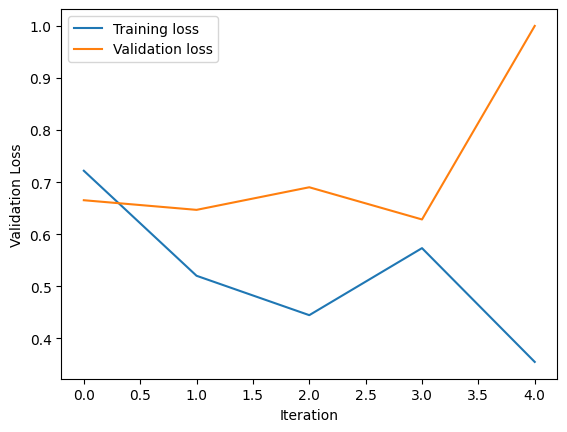

In [ ]:
plot(losses, val_losses)

In [ ]:
# Test accuracy

def test(model, dataloader):

    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for texts, labels in tqdm(dataloader):
            texts = texts.to(device)
            labels = labels.to(device)

            output = model(texts)
            output = output.squeeze()

            predictions = torch.round(torch.sigmoid(output))

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    accuracy = correct / total
    print(f"Test accuracy: {accuracy * 100:.2f}%")

test(simple_model, test_dataloader)

100%|██████████| 196/196 [00:13<00:00, 14.60it/s]

Test accuracy: 74.06%


### Actividad 3

Implemente una red variante al RNN clásico, como un LSTM, GRU, Bi-LSTM, entre otros. Realice el entrenamiento del modelo con el mismo dataset. Realice un breve análisis sobre las diferencias en términos de los resultados, tiempo de ejecución y aspectos que le parezcan relevantes, entre la red implementada en la actividad previa y la red implementada en esta actividad.

In [ ]:
class VariantRNN(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, output_size, dropout=0.2):
        super(VariantRNN, self).__init__()
        
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True, num_layers=1, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        
        # RNN
        out, hidden = self.rnn(x)
        
        out = self.fc(out[:, -1, :])
        
        return out

In [ ]:
variant_model = VariantRNN(vocab_size, 128, 128, 1, dropout=0.2)
variant_model.to(device)

VariantRNN(
  (embedding): Embedding(20002, 128)
  (rnn): GRU(128, 128, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
lr = 0.005
optimizer = torch.optim.Adam(variant_model.parameters(), lr=lr)

In [ ]:
losses, val_losses = train(5, variant_model, criterion, optimizer, train_dataloader, val_dataloader)

100%|██████████| 157/157 [00:01<00:00, 93.34it/s] 


Epoch [1/5], Loss: 0.4580


100%|██████████| 40/40 [00:00<00:00, 242.42it/s]


Epoch [1/5], Validation Loss: 0.5178


100%|██████████| 157/157 [00:01<00:00, 102.77it/s]


Epoch [2/5], Loss: 0.3619


100%|██████████| 40/40 [00:00<00:00, 221.00it/s]


Epoch [2/5], Validation Loss: 0.4520


100%|██████████| 157/157 [00:01<00:00, 100.38it/s]


Epoch [3/5], Loss: 0.2127


100%|██████████| 40/40 [00:00<00:00, 222.22it/s]


Epoch [3/5], Validation Loss: 0.3654


100%|██████████| 157/157 [00:01<00:00, 98.68it/s]


Epoch [4/5], Loss: 0.2312


100%|██████████| 40/40 [00:00<00:00, 217.40it/s]


Epoch [4/5], Validation Loss: 0.3964


100%|██████████| 157/157 [00:01<00:00, 97.33it/s]


Epoch [5/5], Loss: 0.1012


100%|██████████| 40/40 [00:00<00:00, 217.39it/s]

Epoch [5/5], Validation Loss: 0.5109


In [ ]:
# PATH = './variant_rnn.pth'
# torch.save(variant_model.state_dict(), PATH)

In [ ]:
# PATH = './variant_rnn.pth'
# variant_model = VariantRNN(vocabulary_size, 128, 128, 1)
# variant_model.load_state_dict(torch.load(PATH))
# variant_model.to(device)

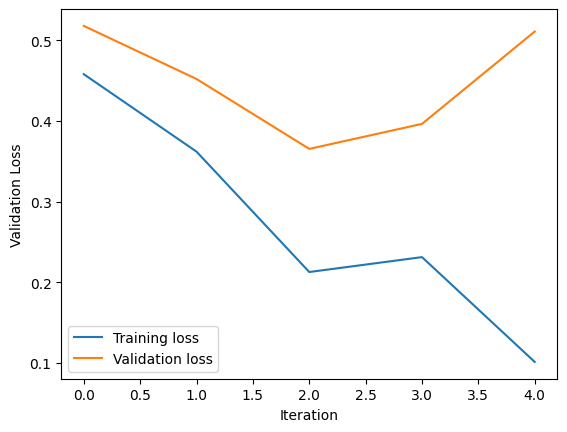

In [ ]:
plot(losses, val_losses)

In [ ]:
test(variant_model, test_dataloader)

100%|██████████| 196/196 [00:13<00:00, 14.02it/s]

Test accuracy: 82.40%


#### SimpleRNN vs VariantRNN

Los resultados obtenidos por VariantRNN son mejores que los de la RNN simple. Para VariantRNN se usó
una RNN tipo GRU, que es una variante de las RNNs que intenta solucionar los problemas de las RNNs
tradicionales. En este caso, la GRU obtuvo mejores resultados que la RNN simple, con una precisión
de 82.4%, mientras que la RNN simple tuvo una precisión de 74.06%.

En cuanto a los tiempos de entrenamiento, se tiene que fueron bastante parecidos, aunque levemente
más lento el entrenamiento de la GRU, así como también en el tiempo de testeo.

Finalmente, en términos de implementación en código, son realmente muy parecidos, con la única diferencia
de que en la GRU se usa una capa de tipo GRU en vez de una capa de tipo RNN.

Cabe destacar que en ambos casos mi entrenamiento tuvo problemas de _overfitting_ y de gradientes, ya
que el _validation_loss_ se volvía muy inestable y no lograba disminuir de forma constante, por lo que
opté por entrenar con un número de _epochs_ menor para evitar el _overfitting_ y secuencias de texto
más cortas para evitar problemas con los gradientes.

## Parte 2: Transformer

### Actividad 4

Responda las siguientes preguntas:



*   ¿Cuáles son los principales aspectos de las redes Transformer?
¿Qué desafíos específicos de las RNNs intenta superar la arquitectura de los Transformers?

    **Respuesta:**....

*   ¿Cuáles son las diferencias entre las capas cross-attention y self-attention?

    **Respuesta:**....

*   ¿Cuáles son las principales características del encoder y el decoder de una red Transformer?

    **Respuesta:**....

*   ¿En qué casos se aplica modelos de tipo encoder? En qué casos se aplica modelos de tipo decoder? ¿En qué casos se aplica modelos de tipo encoder decoder? Responda y justifique su respuesta brevemente.

    **Respuesta:**....

### Actividad 5

En particular, la tarea será sobre generación de reseñas. Es decir que tendrán que implementar una red Transformer y entrenarla con el dataset IMDB para generar texto de reseñas de películas.

A medida que progresa el entrenamiento, muestre algunas instancias de salida del texto generado por el modelo. Para ello considere los puntos inicial, intermedio y final del entrenamiento. Realice un análisis sobre el texto generado y explique brevemente cómo el modelo es capaz de generar texto de reseñas.

Es importante que argumente su elección de los parámetros e hiperparámetros que vaya a utilizar, tales como: cantidad de capas, cantidad de neuronas por capa, función de activación, función de pérdida, etc. En particular, describa el método utilizado para la tokenización de los datos.

En base a: https://debuggercafe.com/text-generation-with-transformers/

In [6]:
# tokenization
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

token_data_train = data_train.copy()
token_data_test = data_test.copy()

# concatenate both datasets

token_data = pd.concat([data_train, data_test], ignore_index=True)

# Fraction the dataset

fraction = 0.1
token_data = token_data.sample(frac=fraction).reset_index(drop=True)

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    # Remove special characters and multiple spaces
    text = re.sub(r'[^a-zA-Z0-9\s.,]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

token_data["text"] = token_data["text"].apply(clean_text)
token_data["text"] = token_data["text"].apply(word_tokenize)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Bruno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\Bruno\AppData\Local\Temp\ipykernel_4648\2561846294.py:22: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text(separator=" ")


In [74]:
# Create a list of sequences of words from the 'text' column

list_of_lists = token_data["text"].tolist()

# Add a newline character to the beginning of each sequence

for i in range(len(list_of_lists)):
    list_of_lists[i].insert(0, "\n")

# Merge all sequences into a single list

all_words = [word for sequence in list_of_lists for word in sequence]

# Subdivide the list into smaller lists of SEQUENCE_LENGTH words

SEQUENCE_LENGTH = 64

sequences = [all_words[i:i+SEQUENCE_LENGTH] for i in range(len(all_words)-SEQUENCE_LENGTH)]

In [89]:
# vocabulary
from collections import Counter

words_count = Counter(all_words)

vocab = list(words_count.keys())

vocab_size = len(vocab)

word_to_int = {word: index for index, word in enumerate(vocab)}
int_to_word = {index: word for index, word in enumerate(vocab)}

print(f"Vocabulary size: {vocab_size}")
print(words_count.most_common(10))

Vocabulary size: 47360
[('the', 56872), (',', 53319), ('.', 53081), ('a', 30653), ('and', 30489), ('of', 28662), ('to', 26336), ('is', 20671), ('in', 17251), ('I', 16263)]
['\n', 'Leonard', 'Rossiter', 'and', 'Frances', 'de', 'la', 'Tour', 'carry', 'this']


In [76]:
# PyTorch datasets

from torch.utils.data import Dataset

class IMDBTextDataset(Dataset):
    def __init__(self, samples, word_to_int):
        self.samples = samples
        self.word_to_int = word_to_int

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        input_seq = torch.LongTensor([self.word_to_int[word] for word in sample[:-1]])
        target_seq = torch.LongTensor([self.word_to_int[word] for word in sample[1:]])
        return input_seq, target_seq

In [77]:
BATCH_SIZE = 64

generation_dataset = IMDBTextDataset(sequences, word_to_int)

In [78]:
generation_dataloader = DataLoader(generation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [79]:
def generate_triangular_mask(size):
    mask = torch.tril(torch.ones(size, size))
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [80]:
class PostionalEncoding(nn.Module):
    def __init__(self, max_len, d_model, dropout=0.2):
        super(PostionalEncoding, self).__init__()

        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [81]:
class MyModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_layers, num_heads, dropout=0.2):
        super(MyModel, self).__init__()

        self.pos_encoder = PostionalEncoding(SEQUENCE_LENGTH, embedding_size)
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=embedding_size, nhead=num_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer=self.decoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        emb = self.embedding(x)
        input_mask = generate_triangular_mask(x.size(1)).to(x.device)

        x = self.pos_encoder(emb)
        x = self.decoder(x, memory=x, tgt_mask=input_mask, memory_mask=input_mask)
        x = self.dropout(x)
        out = self.fc(x)
        return out

In [82]:
EPOCHS = 6
LR = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(vocab_size, 128, 2, 4, dropout=0.2).to(device)

In [83]:
def return_int_vector(text):
    words = text.split()
    words = words if words else ["\n"]
    input_seq = torch.LongTensor([word_to_int[word] for word in words[-SEQUENCE_LENGTH:]]).unsqueeze(0)
    return input_seq

def sample_next(predictions):
    probabilities = F.softmax(predictions[:, -1, :], dim=-1).to(device)
    next_token = torch.argmax(probabilities)
    return int(next_token.to(device))

def text_generator(length, model, sentence=""):
    model.eval()
    output_text = sentence
    for i in range(length):
        int_vector = return_int_vector(sentence)
        if len(int_vector) >= SEQUENCE_LENGTH:
            break
        int_vector = int_vector.to(device)
        with torch.no_grad():
            output = model(int_vector)
        next_token = sample_next(output)
        sentence += " " + int_to_word[next_token]
        if int_to_word[next_token] == "s":
            output_text += "'s"
        elif int_to_word[next_token] == "t" and output_text[-1] == "n":
            output_text += "'t"
        elif int_to_word[next_token] == "m" and output_text[-1] == "I":
            output_text += "'m"
        elif int_to_word[next_token] not in [".", ",", "!", "?"]:
            output_text += " " + int_to_word[next_token]
        else:
            output_text += int_to_word[next_token]
    print(output_text)

In [85]:
# No training

text_generator(100, model)

 finished Taoist Fleeting duo flattered errands bile braincells AWARD actioner Saying Stalag Kamerdaschaft Location nasty Saying Wendell whuppin Bloody Crusaders Wholly debatable bipolarity denomination Newfoundland CAROUSEL lite longing Too scheme cornfields spouse Crusaders Wholly screamer Feminist scurry T.V updating lesbian bipolarity purgatory enterprising Hugh Yang philly downs Lensman Bachelors Tamara y Saying Wendell ROOKIES can discoverd shipped purgatory L.A timelessness Amores Despite Kindred Timberflake Kamerdaschaft Location Despite Kindred reuse wrost bangers stealer spouse WHEN thank philly Warriors WAX posing capsule WHEN thank philly Warriors WAX posing vein snappy LONDON spouse WHEN domineering 70th spouse WHEN domineering 70th blew No.2 Zentropa


In [90]:
import random


def train(model, epochs, criterion, optimizer, train_dataloader, accumulation_steps=1):
    losses = []
    counter = 0
    for epoch in range(epochs):
        model.train()
        for input_sequence, target_sequence in tqdm(train_dataloader):
            counter +=1
            input_sequence = input_sequence.to(device)
            target_sequence = target_sequence.to(device)

            output = model(input_sequence)
            output = output.view(-1, vocab_size)
            target_sequence = target_sequence.view(-1)

            loss = criterion(output, target_sequence)
            loss.backward()

            if (counter + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            if (counter + 1) % 1000 == 0:
                losses.append(loss.item())
                print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

        print(f"Epoch [{epoch+1}/{epochs}]")
        print("Example text at the end of epoch:")
        text_generator(100, model, sentence=random.choice(["I", "The", "One", "It", "Was"]))
        
    return losses

In [91]:
losses = train(model, EPOCHS, nn.CrossEntropyLoss(), torch.optim.Adam(model.parameters(), lr=LR), generation_dataloader, accumulation_steps=4)

  5%|▍         | 1001/20069 [01:04<20:19, 15.64it/s]

Epoch [1/6], Loss: 4.426481246948242


 10%|▉         | 2001/20069 [02:09<20:12, 14.90it/s]

Epoch [1/6], Loss: 4.365966796875


 15%|█▍        | 3001/20069 [03:14<18:19, 15.53it/s]

Epoch [1/6], Loss: 4.323410987854004


 20%|█▉        | 4001/20069 [04:19<16:52, 15.86it/s]

Epoch [1/6], Loss: 4.4004292488098145


 25%|██▍       | 5001/20069 [05:24<16:48, 14.94it/s]

Epoch [1/6], Loss: 4.409407615661621


 30%|██▉       | 6001/20069 [06:29<15:29, 15.14it/s]

Epoch [1/6], Loss: 4.369656562805176


 35%|███▍      | 7001/20069 [07:35<14:06, 15.43it/s]

Epoch [1/6], Loss: 4.353371620178223


 40%|███▉      | 8001/20069 [08:40<12:43, 15.80it/s]

Epoch [1/6], Loss: 4.284581661224365


 45%|████▍     | 9001/20069 [09:44<11:39, 15.81it/s]

Epoch [1/6], Loss: 4.237783432006836


 50%|████▉     | 10001/20069 [10:49<10:40, 15.72it/s]

Epoch [1/6], Loss: 4.349295616149902


 55%|█████▍    | 11001/20069 [11:54<10:18, 14.65it/s]

Epoch [1/6], Loss: 4.300182819366455


 60%|█████▉    | 12001/20069 [12:59<08:30, 15.79it/s]

Epoch [1/6], Loss: 4.205373764038086


 65%|██████▍   | 13001/20069 [14:05<07:29, 15.72it/s]

Epoch [1/6], Loss: 4.231816291809082


 70%|██████▉   | 14001/20069 [15:09<06:32, 15.45it/s]

Epoch [1/6], Loss: 4.290206432342529


 75%|███████▍  | 15001/20069 [16:15<05:22, 15.73it/s]

Epoch [1/6], Loss: 4.249593734741211


 80%|███████▉  | 16001/20069 [17:19<04:16, 15.86it/s]

Epoch [1/6], Loss: 4.176146030426025


 85%|████████▍ | 17001/20069 [18:24<03:16, 15.58it/s]

Epoch [1/6], Loss: 4.18412446975708


 90%|████████▉ | 18001/20069 [19:30<02:12, 15.55it/s]

Epoch [1/6], Loss: 4.218897819519043


 95%|█████████▍| 19001/20069 [20:36<01:09, 15.33it/s]

Epoch [1/6], Loss: 4.189200401306152


100%|█████████▉| 20001/20069 [21:41<00:04, 15.89it/s]

Epoch [1/6], Loss: 4.208927631378174


100%|██████████| 20069/20069 [21:46<00:00, 15.36it/s]


Epoch [1/6]
Example text at the end of epoch:
It's a shame that the film is based on a true story, and it's a very good movie. It's a shame that it's a movie that is a lot of fun to watch. 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 



  5%|▍         | 933/20069 [00:59<20:02, 15.92it/s]

Epoch [2/6], Loss: 4.191831588745117


 10%|▉         | 1933/20069 [02:02<19:46, 15.29it/s]

Epoch [2/6], Loss: 4.175196170806885


 15%|█▍        | 2933/20069 [03:06<18:20, 15.58it/s]

Epoch [2/6], Loss: 4.134439468383789


 20%|█▉        | 3933/20069 [04:11<17:07, 15.70it/s]

Epoch [2/6], Loss: 4.093816757202148


 25%|██▍       | 4933/20069 [05:14<16:48, 15.01it/s]

Epoch [2/6], Loss: 4.091808795928955


 30%|██▉       | 5933/20069 [06:19<15:27, 15.25it/s]

Epoch [2/6], Loss: 4.159545421600342


 35%|███▍      | 6933/20069 [07:24<13:58, 15.66it/s]

Epoch [2/6], Loss: 4.060334205627441


 40%|███▉      | 7933/20069 [08:29<13:04, 15.47it/s]

Epoch [2/6], Loss: 4.114936828613281


 45%|████▍     | 8933/20069 [09:33<11:39, 15.93it/s]

Epoch [2/6], Loss: 4.035966873168945


 49%|████▉     | 9933/20069 [10:37<10:45, 15.69it/s]

Epoch [2/6], Loss: 4.121526718139648


 54%|█████▍    | 10933/20069 [11:40<09:46, 15.57it/s]

Epoch [2/6], Loss: 4.102473735809326


 59%|█████▉    | 11933/20069 [12:45<08:44, 15.50it/s]

Epoch [2/6], Loss: 4.152060508728027


 64%|██████▍   | 12933/20069 [13:50<07:44, 15.35it/s]

Epoch [2/6], Loss: 4.011417865753174


 69%|██████▉   | 13931/20069 [14:55<06:35, 15.53it/s]

Epoch [2/6], Loss: 4.066574573516846


 74%|███████▍  | 14933/20069 [16:00<05:25, 15.78it/s]

Epoch [2/6], Loss: 4.047986030578613


 79%|███████▉  | 15933/20069 [17:04<04:37, 14.93it/s]

Epoch [2/6], Loss: 4.0729594230651855


 84%|████████▍ | 16933/20069 [18:09<03:20, 15.62it/s]

Epoch [2/6], Loss: 4.05279016494751


 89%|████████▉ | 17933/20069 [19:13<02:16, 15.66it/s]

Epoch [2/6], Loss: 4.081135272979736


 94%|█████████▍| 18933/20069 [20:18<01:14, 15.20it/s]

Epoch [2/6], Loss: 4.047982215881348


 99%|█████████▉| 19933/20069 [21:23<00:08, 15.52it/s]

Epoch [2/6], Loss: 4.031469345092773


100%|██████████| 20069/20069 [21:32<00:00, 15.53it/s]


Epoch [2/6]
Example text at the end of epoch:
The film is a bit slow, and the acting is very good, and the acting is very good. The acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great, the acting is great,


  4%|▍         | 863/20069 [00:55<20:38, 15.51it/s]

Epoch [3/6], Loss: 4.032651424407959


  9%|▉         | 1863/20069 [02:00<19:10, 15.82it/s]

Epoch [3/6], Loss: 3.9143898487091064


 14%|█▍        | 2863/20069 [03:04<18:08, 15.80it/s]

Epoch [3/6], Loss: 3.9929921627044678


 19%|█▉        | 3863/20069 [04:08<17:13, 15.68it/s]

Epoch [3/6], Loss: 3.9432857036590576


 24%|██▍       | 4863/20069 [05:13<15:55, 15.91it/s]

Epoch [3/6], Loss: 3.988680362701416


 29%|██▉       | 5863/20069 [06:17<15:01, 15.76it/s]

Epoch [3/6], Loss: 3.9652440547943115


 34%|███▍      | 6863/20069 [07:21<14:03, 15.65it/s]

Epoch [3/6], Loss: 3.904832363128662


 39%|███▉      | 7863/20069 [08:24<12:56, 15.72it/s]

Epoch [3/6], Loss: 3.9844775199890137


 44%|████▍     | 8863/20069 [09:28<11:50, 15.78it/s]

Epoch [3/6], Loss: 3.992349147796631


 49%|████▉     | 9863/20069 [10:32<10:42, 15.89it/s]

Epoch [3/6], Loss: 3.9476544857025146


 54%|█████▍    | 10863/20069 [11:36<09:56, 15.44it/s]

Epoch [3/6], Loss: 4.037354469299316


 59%|█████▉    | 11863/20069 [12:40<09:02, 15.14it/s]

Epoch [3/6], Loss: 3.8747689723968506


 64%|██████▍   | 12863/20069 [13:43<07:43, 15.56it/s]

Epoch [3/6], Loss: 3.8980557918548584


 69%|██████▉   | 13863/20069 [14:47<06:32, 15.82it/s]

Epoch [3/6], Loss: 3.913590431213379


 74%|███████▍  | 14863/20069 [15:51<05:25, 15.98it/s]

Epoch [3/6], Loss: 3.8633229732513428


 79%|███████▉  | 15863/20069 [16:54<04:26, 15.77it/s]

Epoch [3/6], Loss: 3.929241418838501


 84%|████████▍ | 16863/20069 [17:59<03:20, 15.96it/s]

Epoch [3/6], Loss: 3.792217493057251


 89%|████████▉ | 17863/20069 [19:03<02:19, 15.81it/s]

Epoch [3/6], Loss: 3.856790542602539


 94%|█████████▍| 18863/20069 [20:07<01:16, 15.72it/s]

Epoch [3/6], Loss: 3.8997256755828857


 99%|█████████▉| 19863/20069 [21:10<00:12, 15.90it/s]

Epoch [3/6], Loss: 3.8687734603881836


100%|██████████| 20069/20069 [21:24<00:00, 15.62it/s]


Epoch [3/6]
Example text at the end of epoch:
One of the most beautiful actresses of the film. The film is a definite reason to watch this movie. 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 



  4%|▍         | 795/20069 [00:51<20:17, 15.83it/s]

Epoch [4/6], Loss: 3.853910207748413


  9%|▉         | 1795/20069 [01:57<19:45, 15.41it/s]

Epoch [4/6], Loss: 3.789726972579956


 14%|█▍        | 2793/20069 [03:01<19:19, 14.90it/s]

Epoch [4/6], Loss: 3.8726537227630615


 19%|█▉        | 3795/20069 [04:06<17:27, 15.53it/s]

Epoch [4/6], Loss: 3.8936948776245117


 24%|██▍       | 4795/20069 [05:10<16:22, 15.55it/s]

Epoch [4/6], Loss: 3.8214025497436523


 29%|██▉       | 5795/20069 [06:14<15:25, 15.43it/s]

Epoch [4/6], Loss: 3.912445306777954


 34%|███▍      | 6795/20069 [07:19<14:19, 15.44it/s]

Epoch [4/6], Loss: 3.8620095252990723


 39%|███▉      | 7795/20069 [08:23<13:10, 15.53it/s]

Epoch [4/6], Loss: 3.7879903316497803


 44%|████▍     | 8795/20069 [09:28<12:22, 15.18it/s]

Epoch [4/6], Loss: 3.820158004760742


 49%|████▉     | 9795/20069 [10:33<11:17, 15.17it/s]

Epoch [4/6], Loss: 3.7628157138824463


 54%|█████▍    | 10795/20069 [11:38<10:02, 15.40it/s]

Epoch [4/6], Loss: 3.743403434753418


 59%|█████▉    | 11795/20069 [12:43<08:44, 15.77it/s]

Epoch [4/6], Loss: 3.771806240081787


 64%|██████▍   | 12795/20069 [13:46<07:40, 15.80it/s]

Epoch [4/6], Loss: 3.760551929473877


 69%|██████▊   | 13795/20069 [14:51<06:42, 15.60it/s]

Epoch [4/6], Loss: 3.784567356109619


 74%|███████▎  | 14793/20069 [15:57<05:40, 15.51it/s]

Epoch [4/6], Loss: 3.822680711746216


 79%|███████▊  | 15795/20069 [17:01<04:30, 15.78it/s]

Epoch [4/6], Loss: 3.8128952980041504


 84%|████████▎ | 16795/20069 [18:05<03:30, 15.54it/s]

Epoch [4/6], Loss: 3.7063205242156982


 89%|████████▊ | 17793/20069 [19:09<02:25, 15.69it/s]

Epoch [4/6], Loss: 3.8638532161712646


 94%|█████████▎| 18795/20069 [20:13<01:21, 15.69it/s]

Epoch [4/6], Loss: 3.726815938949585


 99%|█████████▊| 19795/20069 [21:17<00:17, 15.79it/s]

Epoch [4/6], Loss: 3.7655012607574463


100%|██████████| 20069/20069 [21:34<00:00, 15.50it/s]


Epoch [4/6]
Example text at the end of epoch:
One of the most beautiful movies I have ever seen. I have seen it in my entire life. I have never seen a movie in my life. I'm not sure why. I'm not sure what to say about this movie is that it is a movie that is not a bad movie. It is a movie that is so bad it is bad that it is bad. It's not a bad movie. It's not a bad movie. It's not a bad movie. It's not a bad


  4%|▎         | 725/20069 [00:46<20:38, 15.61it/s]

Epoch [5/6], Loss: 3.764765739440918


  9%|▊         | 1725/20069 [01:50<19:28, 15.70it/s]

Epoch [5/6], Loss: 3.7209408283233643


 14%|█▎        | 2725/20069 [02:54<18:15, 15.83it/s]

Epoch [5/6], Loss: 3.734375476837158


 19%|█▊        | 3725/20069 [03:58<18:34, 14.66it/s]

Epoch [5/6], Loss: 3.7435405254364014


 24%|██▎       | 4725/20069 [05:03<16:23, 15.61it/s]

Epoch [5/6], Loss: 3.7304036617279053


 29%|██▊       | 5725/20069 [06:09<15:28, 15.45it/s]

Epoch [5/6], Loss: 3.67797589302063


 34%|███▎      | 6725/20069 [07:14<14:45, 15.07it/s]

Epoch [5/6], Loss: 3.744058847427368


 38%|███▊      | 7725/20069 [08:19<13:11, 15.60it/s]

Epoch [5/6], Loss: 3.7767508029937744


 43%|████▎     | 8725/20069 [09:25<12:41, 14.89it/s]

Epoch [5/6], Loss: 3.7222537994384766


 48%|████▊     | 9725/20069 [10:30<11:02, 15.62it/s]

Epoch [5/6], Loss: 3.6797235012054443


 53%|█████▎    | 10725/20069 [11:35<10:07, 15.39it/s]

Epoch [5/6], Loss: 3.7320635318756104


 58%|█████▊    | 11725/20069 [12:40<08:59, 15.47it/s]

Epoch [5/6], Loss: 3.6819732189178467


 63%|██████▎   | 12725/20069 [13:45<07:59, 15.30it/s]

Epoch [5/6], Loss: 3.6303086280822754


 68%|██████▊   | 13725/20069 [14:50<06:48, 15.54it/s]

Epoch [5/6], Loss: 3.654919147491455


 73%|███████▎  | 14725/20069 [15:56<06:01, 14.79it/s]

Epoch [5/6], Loss: 3.674851655960083


 78%|███████▊  | 15725/20069 [17:01<04:45, 15.21it/s]

Epoch [5/6], Loss: 3.6052699089050293


 83%|████████▎ | 16725/20069 [18:07<03:33, 15.68it/s]

Epoch [5/6], Loss: 3.7325356006622314


 88%|████████▊ | 17725/20069 [19:12<02:31, 15.44it/s]

Epoch [5/6], Loss: 3.721224069595337


 93%|█████████▎| 18725/20069 [20:18<01:28, 15.26it/s]

Epoch [5/6], Loss: 3.703986644744873


 98%|█████████▊| 19725/20069 [21:23<00:22, 15.57it/s]

Epoch [5/6], Loss: 3.6294143199920654


100%|██████████| 20069/20069 [21:45<00:00, 15.37it/s]


Epoch [5/6]
Example text at the end of epoch:
The film is a collage of conversations with a twist and a twist at the end of the film. The plot is very predictable, and the acting is very poor, the acting is poor, the acting is poor, the script is poor, the acting is poor, the script is poor, the acting is poor, the script is poor, the acting is poor, the script is poor, the acting is poor, the script is poor, the acting is poor, the script is poor, the acting is


  3%|▎         | 657/20069 [00:42<21:09, 15.29it/s]

Epoch [6/6], Loss: 3.658482313156128


  8%|▊         | 1657/20069 [01:47<19:55, 15.40it/s]

Epoch [6/6], Loss: 3.690143585205078


 13%|█▎        | 2657/20069 [02:52<18:48, 15.43it/s]

Epoch [6/6], Loss: 3.6527860164642334


 18%|█▊        | 3657/20069 [03:57<18:04, 15.13it/s]

Epoch [6/6], Loss: 3.637606143951416


 23%|██▎       | 4657/20069 [05:03<16:51, 15.23it/s]

Epoch [6/6], Loss: 3.7380211353302


 28%|██▊       | 5657/20069 [06:08<15:31, 15.47it/s]

Epoch [6/6], Loss: 3.556901216506958


 33%|███▎      | 6657/20069 [07:13<14:38, 15.27it/s]

Epoch [6/6], Loss: 3.6247007846832275


 38%|███▊      | 7657/20069 [08:18<13:34, 15.23it/s]

Epoch [6/6], Loss: 3.653618574142456


 43%|████▎     | 8657/20069 [09:24<12:04, 15.75it/s]

Epoch [6/6], Loss: 3.648444890975952


 48%|████▊     | 9657/20069 [10:30<11:36, 14.95it/s]

Epoch [6/6], Loss: 3.6189513206481934


 53%|█████▎    | 10657/20069 [11:35<10:02, 15.63it/s]

Epoch [6/6], Loss: 3.6626856327056885


 58%|█████▊    | 11657/20069 [12:39<09:01, 15.55it/s]

Epoch [6/6], Loss: 3.5549063682556152


 63%|██████▎   | 12657/20069 [13:43<08:05, 15.27it/s]

Epoch [6/6], Loss: 3.549936532974243


 68%|██████▊   | 13657/20069 [14:47<06:48, 15.68it/s]

Epoch [6/6], Loss: 3.664804220199585


 73%|███████▎  | 14657/20069 [15:51<05:46, 15.62it/s]

Epoch [6/6], Loss: 3.5201668739318848


 78%|███████▊  | 15657/20069 [16:55<04:41, 15.70it/s]

Epoch [6/6], Loss: 3.5796494483947754


 83%|████████▎ | 16657/20069 [18:00<03:42, 15.36it/s]

Epoch [6/6], Loss: 3.4874444007873535


 88%|████████▊ | 17657/20069 [19:03<02:31, 15.88it/s]

Epoch [6/6], Loss: 3.5914344787597656


 93%|█████████▎| 18657/20069 [20:07<01:29, 15.76it/s]

Epoch [6/6], Loss: 3.580315113067627


 98%|█████████▊| 19657/20069 [21:12<00:26, 15.60it/s]

Epoch [6/6], Loss: 3.517347812652588


100%|██████████| 20069/20069 [21:38<00:00, 15.45it/s]


Epoch [6/6]
Example text at the end of epoch:
Was it a good movie. It's a shame that the director was so bad that it was made in the first place. The acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the acting was terrible, the


In [96]:
# Text example after training

text_generator(100, model, sentence=random.choice(["I", "The", "One", "It", "Was"]))

I'm not sure what the director was doing. I'm not sure what the director was doing. I'm not sure what the director was doing. I'm not sure what the director was doing. I'm not sure what the director was doing. I'm not sure what the director was doing. I'm not sure what to expect. I'm not sure if I was a fan of the original, but I was wrong. I'm not sure what to expect. I'm not sure if I was


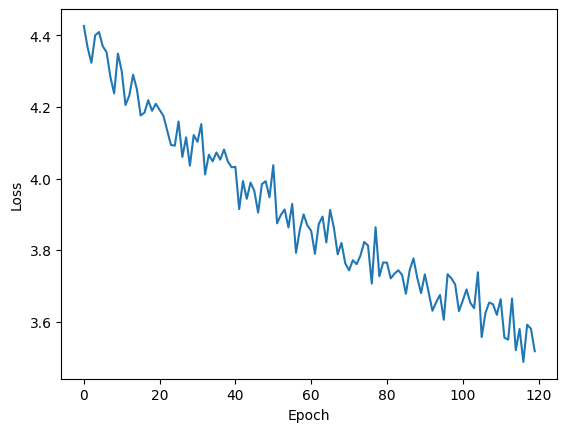

In [100]:
plot(losses)

In [102]:
# PATH = './text_generator_1.pth'
# torch.save(model.state_dict(), PATH)

In [ ]:
# PATH = './simple_rnn.pth'
# simple_model = SimpleRNN(vocabulary_size, 128, 128, 1)
# simple_model.load_state_dict(torch.load(PATH))
# simple_model.to(device)

La siguiente celda es un ejemplo del entrenamiento de su modelo y de la generación de reseñas que realiza su modelo entrenado. En este caso se muestra la generación de 2000 tokens.

In [ ]:
model = MyModel()

train(model)

num_tokens = 2000

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=num_tokens)[0].tolist()))

0.224306 M parameters
step 0: train loss 5.3014, val loss 5.3014
step 100: train loss 2.7339, val loss 2.7166
step 200: train loss 2.5480, val loss 2.5588
step 300: train loss 2.4732, val loss 2.4783
step 400: train loss 2.3983, val loss 2.3997
step 500: train loss 2.3159, val loss 2.3250
step 600: train loss 2.2822, val loss 2.2755
step 700: train loss 2.2273, val loss 2.2159
step 800: train loss 2.1654, val loss 2.1702
step 900: train loss 2.1472, val loss 2.1538
step 1000: train loss 2.1127, val loss 2.1100
step 1100: train loss 2.0843, val loss 2.0968
step 1200: train loss 2.0706, val loss 2.0647
step 1300: train loss 2.0495, val loss 2.0576
step 1400: train loss 2.0166, val loss 2.0264
step 1500: train loss 2.0031, val loss 1.9983
step 1600: train loss 1.9816, val loss 1.9836
step 1700: train loss 1.9620, val loss 1.9739
step 1800: train loss 1.9528, val loss 1.9667
step 1900: train loss 1.9252, val loss 1.9404
step 2000: train loss 1.9206, val loss 1.9348
step 2100: train loss 1.

In [ ]:
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

Review: (TH Of E NOU'NYTN CE) No jealloa girl suwital. Unounder. I gon that HANEY SENK. SHEEG. All is helpinnes, that is job and AltohCRE: Fronk AGE A Sdenterns Review: Lusbe Allf Flaegray Ram-, high scist, butment was little nothim to yet. There been turn the good much, and thought be ver factuul to one yous heldined expy woutch be in creadity for Orché no culla real on monstanshing takeour ly grourie and some and panter and about my about crist? Well by infully. She Nebs and I wald they MTIE FOMD, Alexra TV Oh- hard, it those diffect, tries and Fene, more get yong trody or bad a torie writh this, you pay.<br /> /><br />I `00 a liude show ence have unding the tinfully. He right Combering Jet encesten with (looking, stakes) is a lost get it on in the film, but that stophiles it the bere I watch zitious that scene the `T.. Nonzeplay? The goals bad do - in clasks of his for than asks and to but. On bout, doire and relazing, the and the criseum and tract crimitly watchonde thip is the sur

### Actividad 6

A partir del modelo generativo de la anterior actividad, realice los ajustes necesarios al modelo para mejorar la calidad de las reseñas generadas. Se espera que el modelo sea capaz de generar reseñas de mejor calidad en comparación a la actividad previa. Para ello, investigue y agregue otros datasets públicos de reseñas de películas u otro tipo.